# Using VQE with Qiskit

In this Jupyter notebook, we are going to demonstrate how to use VQE (Variational Quantum Eigensolver) on both simulator and real quantum machine.

We will consider a simple quantum chemistry problem. We will imagine that we have two atoms of hydrogen forming an $H_2$ moledule and that we want to compute its ground state and its energy. We will accomplish this by using Qiskit Nature package.

List of content:

1.  [Finding the ground state](#1---finding-the-ground-state)
2.  [Finding excited states with Qiskit](#2---finding-excited-states-with-qiskit)
3.  [Molecular problems](#3---molecular-problems)
4.  [Running VQE on quantum computers](#4---running-vqe-on-quantum-computers)

## 1.   Finding the ground state

### Hamiltonians

The Hamiltonians that we have considered so far are called **qubit Hamiltonian**, while the one that we need to describe the energy of the $H_2$ molecule is called a **fermionic Hamiltonian**.

To obtain the fermionic Hamiltonian for the dihydrogen molecule with Qiskit, we need to install the `Qiskit Nature package` and `pyscf` library, which is used for the computational chemistry calculations. 

### Packages
Please run the following code incase you haven't installed `Qiskit Nature package` yet.
1. Qiskit Nature
    -   Installation: https://qiskit-community.github.io/qiskit-nature/getting_started.html
    -   Overview: https://qiskit-community.github.io/qiskit-nature/index.html
2. PySCF:
    -   Installation: https://pyscf.org/install.html#install-with-pip
    -   Quickstart: https://pyscf.org/index.html


In [1]:
#! pip install qiskit-nature
#! pip install --prefer-binary pyscf

We first define out molecule. Our molecule have two hydrogen atoms located at coordinates (0,0,-0.37) and (0,0,0.37)(measured in angstroms), which is close to an equilibrium state for this molecle. We are using the default parameters, such as establishing that the molecule is not charged. Then we defin an electronic structure problem by using `PySCF` library. This library helps us computing the fermionic Hamiltonian taht takes into account the different possible configurations for the electrons of the two hydrogen atoms. This is accomplished by **second quantization**.

### Getting Start: Obtaining an initial Hartree-Fock solution

Reference: 
1. [Tutorial: Electronic structure (Qiskit Nature 0.7.2)](https://qiskit-community.github.io/qiskit-nature/tutorials/01_electronic_structure.html)

In [2]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

# Use PySCF, a classical computational chemistry software
# package, to compute the one-body and two-body integrals in
# electronic-orbital basis, necessary to form the Fermionic operator
driver = PySCFDriver(
    atom="H 0 0 -.37; H 0 0 0.37",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

problem = driver.run()
print(problem)

Running this driver, will yield an `ElectronicStructureProblem`, Qiskit Nature’s representation of the electronic structure problem which we are interested in solving. For further information about the drivers, see https://qiskit-community.github.io/qiskit-nature/apidocs/qiskit_nature.second_q.drivers.html

### The ElectronicStructureProblem and its components

In [3]:
hamiltonian = problem.hamiltonian

coefficients = hamiltonian.electronic_integrals
print(coefficients.alpha)


Polynomial Tensor
 "+-":
array([[-1.25330979e+00, -2.63594031e-16],
       [-2.58579021e-16, -4.75068849e-01]])
 "++--":
array([ 6.74755927e-01, -2.94385769e-17,  1.81210462e-01,  6.63711401e-01,
        3.72896665e-16,  6.97651504e-01])


In [4]:
fermionic_op = hamiltonian.second_q_op()
print(fermionic_op)

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.2533097866459777 * ( +_0 -_0 )
+ -0.4750688487721779 * ( +_1 -_1 )
+ -1.2533097866459777 * ( +_2 -_2 )
+ -0.4750688487721779 * ( +_3 -_3 )
+ 0.33737796340722426 * ( +_0 +_0 -_0 -_0 )
+ 0.33185570067540693 * ( +_0 +_1 -_1 -_0 )
+ 0.33737796340722426 * ( +_0 +_2 -_2 -_0 )
+ 0.33185570067540693 * ( +_0 +_3 -_3 -_0 )
+ 0.09060523100759854 * ( +_0 +_0 -_1 -_1 )
+ 0.09060523100759854 * ( +_0 +_1 -_0 -_1 )
+ 0.09060523100759854 * ( +_0 +_2 -_3 -_1 )
+ 0.09060523100759854 * ( +_0 +_3 -_2 -_1 )
+ 0.09060523100759854 * ( +_1 +_0 -_1 -_0 )
+ 0.09060523100759854 * ( +_1 +_1 -_0 -_0 )
+ 0.09060523100759854 * ( +_1 +_2 -_3 -_0 )
+ 0.09060523100759854 * ( +_1 +_3 -_2 -_0 )
+ 0.33185570067540693 * ( +_1 +_0 -_0 -_1 )
+ 0.34882575224523166 * ( +_1 +_1 -_1 -_1 )
+ 0.33185570067540693 * ( +_1 +_2 -_2 -_1 )
+ 0.34882575224523166 * ( +_1 +_3 -_3 -_1 )
+ 0.33737796340722426 * ( +_2 +_0 -_0 -_2 )
+ 0.33185570067540693 * ( +_2 +_1 -_1 -_2 )
+ 0.3

This is a truncated view of the fermionic Hamiltonian, invloving something called **creation** and **annihilation** operators that describe how electrons move from one orbital to another.

### Mapping
To use the quantum computer, we need to transform the fermionic Hamiltonian into a qubit Hamiltonian, involving Pauli gates. See [references](#references) for more info.

In [5]:
# setup the qubit mapper
from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()
qhamiltonian = mapper.map(fermionic_op)
print("Qubit Hamiltonian:")
print(qhamiltonian)

Qubit Hamiltonian:
SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81217061+0.j,  0.17141283+0.j, -0.22343154+0.j,  0.17141283+0.j,
 -0.22343154+0.j,  0.12062523+0.j,  0.16868898+0.j,  0.16592785+0.j,
  0.04530262+0.j,  0.04530262+0.j,  0.04530262+0.j,  0.04530262+0.j,
  0.16592785+0.j,  0.17441288+0.j,  0.12062523+0.j])


Now we have successfully transformed fermionic Hamiltonian into our familiar qubit Hamiltonian! We can observe that there are 4 qubits , involving tensor products of $I$, $X$, $Y$, and $Z$ gates.

In [6]:
# setup the classical optimizer for the VQE
from qiskit_algorithms.optimizers import L_BFGS_B, COBYLA, SLSQP

optimizer_L_BFGS_B = L_BFGS_B()
optimizer_COBYLA = COBYLA()
optimizer_SLSQP = SLSQP()

### The Solvers

In [7]:
# setup the estimator primitive for the VQE
from qiskit.primitives import Estimator

estimator = Estimator()

/var/folders/kz/_mr3r3b55qd2r5hd025yvpfw0000gn/T/ipykernel_77405/2872279188.py:4: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


### Using VQE with qubit Hamiltonians

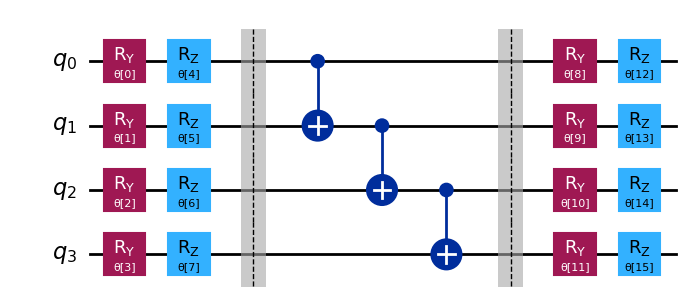

In [8]:
from qiskit.circuit.library import EfficientSU2

ansatz_Eff = EfficientSU2(num_qubits=4, reps=1, entanglement="linear", insert_barriers=True)
ansatz_Eff.decompose().draw("mpl")

As you can see, we are using 16 different tunable parameters, represented by $\theta[0], \cdots, \theta[15]$ in the figure.

In [9]:
# set up our actual VQE instance with EfficientU2 solver
from qiskit_algorithms import VQE

vqe_optimizer_SLSQP = VQE(estimator, ansatz_Eff, optimizer_SLSQP)

We can try to use `compute_minimum_eigenvalue` and `NumPyMinimumEigensolver` to solve our problem by the following two examples. We start with the `compute_minimum_eigenvalue` first.

In [10]:
result = vqe_optimizer_SLSQP.compute_minimum_eigenvalue(qhamiltonian)
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 478,
    'eigenvalue': np.float64(-1.8318632765251293),
    'optimal_circuit': <qiskit.circuit.library.n_local.efficient_su2.EfficientSU2 object at 0x120d79bd0>,
    'optimal_parameters': {   ParameterVectorElement(θ[12]): np.float64(2.751523847789954),
                              ParameterVectorElement(θ[3]): np.float64(-1.5706955122871569),
                              ParameterVectorElement(θ[2]): np.float64(1.0654359386453427),
                              ParameterVectorElement(θ[13]): np.float64(-1.2181093289273772),
                              ParameterVectorElement(θ[0]): np.float64(3.141592653589793),
                              ParameterVectorElement(θ[15]): np.float64(-2.9413089677398734),
                              ParameterVectorElement(θ[7]): np.float64(-3.141592653589793),
                              ParameterVectorElement(θ[14]): np.float64(3.1264224104305742),
                              Par

As you can see, we have obtain the optimal values for the circuit parameters, the state that is generated with those parameters (the `eigenstate` field) and what we were looking for: the energy state, which ihappens to be about $-1.8524$ hartree (the unit of energy commonly used in molecular orbital calculation). This means that we have solved our problem. How can we make sure these values are correct?

In this case, since we have only used 4 qubits, therefore, we can check directly with the classical solver,`NumPyMinimumEigensolver`, that finds the exact ground state.

Next we try the `NumPyMinimumEigensolver`.

In [11]:
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

solver = NumPyMinimumEigensolver()
result = solver.compute_minimum_eigenvalue(qhamiltonian)
print(result)

{   'aux_operators_evaluated': None,
    'eigenstate': Statevector([ 3.05311332e-16+7.04731412e-19j,
             -2.22044605e-16-1.11022302e-16j,
              3.46944695e-17-8.32667268e-17j,
              1.11022302e-16-2.77555756e-17j,
              2.77555756e-17-4.16333634e-17j,
             -6.67316913e-01-7.36221442e-01j,
             -1.11022302e-16-1.66533454e-16j,
             -9.71445147e-17+1.38777878e-16j,
             -1.66533454e-16-3.46944695e-17j,
              9.62771529e-17+1.38777878e-16j,
              7.55826341e-02+8.33870007e-02j,
             -1.52655666e-16+4.71844785e-16j,
             -1.66533454e-16+8.32667268e-17j,
              2.77555756e-17-1.66533454e-16j,
             -4.44089210e-16+5.55111512e-16j,
             -2.49800181e-16+1.66533454e-16j],
            dims=(2, 2, 2, 2)),
    'eigenvalue': np.float64(-1.8523881735695835)}


This is more concise than the VQE output, but the final energy is almost equal to the one we had obtained previously. Congrats! we have successfully solved a molecular problem with VQE!!

## 2.   Finding excited states with Qiskit

Back to the VQE page, we have already know not only how to use VQE iteratively to find the ground state, but also states of higher energy (excited states). The algorithm we are about to introduce is the ***Variational Quantum Deflation (VQD)*** and how to implement it by using Qiskit.

Reference: 
1. [Qiskit VQD](https://qiskit-community.github.io/qiskit-algorithms/tutorials/04_vqd.html)
2. [Qiskit-nature 04_excited_states_solvers.ipynb](https://github.com/qiskit-community/qiskit-nature/blob/af569523110fb88395aa9c17bc0532d9646163f8/docs/tutorials/04_excited_states_solvers.ipynb)

In [12]:
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler

sampler2 = Sampler()
fidelity = ComputeUncompute(sampler2)

/var/folders/kz/_mr3r3b55qd2r5hd025yvpfw0000gn/T/ipykernel_77405/1466006858.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler2 = Sampler()


In [13]:
from qiskit_algorithms import VQD

vqd = VQD(ansatz=ansatz_Eff,
          optimizer=optimizer_SLSQP,
          fidelity=fidelity,
          k=3,
          estimator = Estimator())

result = vqd.compute_eigenvalues(qhamiltonian)
print(result)

/var/folders/kz/_mr3r3b55qd2r5hd025yvpfw0000gn/T/ipykernel_77405/3226737995.py:7: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator())


{   'aux_operators_evaluated': None,
    'cost_function_evals': array([204, 547, 823]),
    'eigenvalues': array([-1.83186342+0.j, -1.24587581+0.j, -1.253305  +0.j]),
    'optimal_circuits': [   <qiskit.circuit.library.n_local.efficient_su2.EfficientSU2 object at 0x120c2f9d0>,
    'optimal_parameters': [   {   ParameterVectorElement(θ[12]): np.float64(-1.4116592079695565),
                                  ParameterVectorElement(θ[3]): np.float64(1.570752192086874),
                                  ParameterVectorElement(θ[2]): np.float64(-0.63957631081702),
                                  ParameterVectorElement(θ[13]): np.float64(-0.0349151200774026),
                                  ParameterVectorElement(θ[0]): np.float64(-7.620858351464622e-05),
                                  ParameterVectorElement(θ[15]): np.float64(-0.9767527436944802),
                                  ParameterVectorElement(θ[7]): np.float64(-3.141592653589793),
                                  Paramete

The `k` parameter is the one that we use to specify the number of eigenstates.

We get the ground state energy $-1.85238735+0.j$ and the first excited state energy of $-1.25330263+0.j$. Let's the first excited state energy value with the direct `NumPyEigensolver` and `ExcitedStatesEigensolver`!

In [14]:
from qiskit_nature.second_q.algorithms  import QEOM, EvaluationRule, GroundStateEigensolver

gse = GroundStateEigensolver(mapper, solver)
# The qEOM algorithm is simply instantiated with the chosen ground state solver and Estimator primitive
qeom_excited_states_solver = QEOM(gse, estimator, "sd", EvaluationRule.ALL)


In [15]:
from qiskit_algorithms import NumPyEigensolver

numpy_solver = NumPyEigensolver(k=2, filter_criterion=problem.get_default_filter_criterion())

In [16]:
from qiskit_nature.second_q.algorithms import ExcitedStatesEigensolver

numpy_excited_states_solver = ExcitedStatesEigensolver(mapper, numpy_solver)
numpy_results = numpy_excited_states_solver.solve(problem)

qeom_results = qeom_excited_states_solver.solve(problem)

print("numpy_results:\n", numpy_results)
print("\n\n")
print("qeom_results:\n", qeom_results)

numpy_results:
 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.85238817357
  - computed part:      -1.85238817357
~ Nuclear repulsion energy (Hartree): 0.715104339081
> Total ground state energy (Hartree): -1.137283834489
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -0.883456772052
> Total excited state energy (Hartree): -0.168352432971
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  1:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.0]
    - computed part:      [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 
  1: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.0]
    - computed part:      [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
      

Here is the result from `NumPyEigensolver`:

=== EXCITED STATE ENERGIES ===

The 1st excited state:
* Electronic excited state energy (Hartree): ***-0.883456772052***
> Total excited state energy (Hartree): -0.168352432971

and these are the result from `ExcitedStatesEigensolver`:

=== EXCITED STATE ENERGIES ===
 
The 1st excited state:
* Electronic excited state energy (Hartree): -1.245877696083
> Total excited state energy (Hartree): -0.530773357001

The 2nd excited state:
* Electronic excited state energy (Hartree): ***-0.883456772052***
> Total excited state energy (Hartree): -0.168352432971

## 3.   Molecular problems

We can also use VQE directly with molecular problems that we define with the help of the Qiskit Nature utilities. For example, we can use a VQE instance to solve the electronic problem that we defined in the previous subsection.

The choose of the ansatz should take into account information from the problem domain. This is the case of the ***Unitary Coupled-Cluster Singles and Doubles*** or ***UCCSD*** ansatz, which is widely used for molecular computations. Let's construct this ansatz!

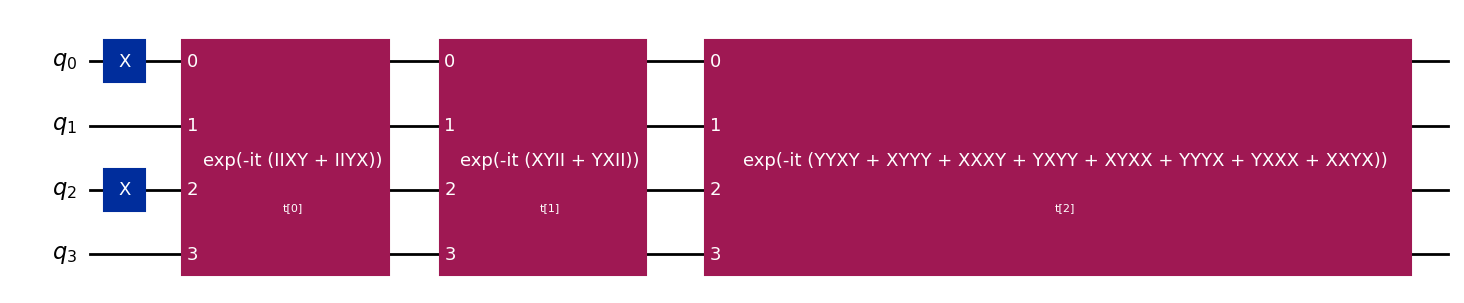

In [17]:
# setup the ansatz for VQE
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)
ansatz.decompose().draw("mpl")


As you can see, the ansatz invloves exponential funcitons of tensor products of Pauli matrices. There are also two $X$ gates at the beginning of the circuit that set the initial state to which the variational form is later applied. In this case, the state is called the ***Hartree-Fock*** state, again a widely used option when solving molecular problems with quantum computer.

Once we have selected out ansatz, we can define a VQE instance by the following instructions

In [18]:
# set up our actual VQE instance
from qiskit_algorithms import VQE

vqe_optimizer_L_BFGS_B = VQE(estimator, ansatz, optimizer_L_BFGS_B)
# ensure that the optimizer starts in the all-zero state which corresponds to
# the Hartree-Fock starting point
vqe_optimizer_L_BFGS_B.initial_point = [0] * ansatz.num_parameters

In [19]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

calc = GroundStateEigensolver(mapper, vqe_optimizer_L_BFGS_B)
res = calc.solve(problem)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.85238817357
  - computed part:      -1.85238817357
~ Nuclear repulsion energy (Hartree): 0.715104339081
> Total ground state energy (Hartree): -1.137283834488
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  -0.000000039235]
    - computed part:      [0.0  0.0  -0.000000039235]
  > Dipole moment (a.u.): [0.0  0.0  0.000000039235]  Total: 0.000000039235
                 (debye): [0.0  0.0  0.000000099726]  Total: 0.000000099726
 


We are providing the solver not only with the Hamiltonian, but with the whole problem, and it cab use that information to reconstruct the meaning of the calculations in the physical terms. For instance, we now get some bonus information such as the **total ground state energy**, which is the sum of the energy due to the electronic structure (the one that we had computed previously) and the energy due to nuclear repulsion.

## 4.   Running VQE on Quantum computers

In [20]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.primitives import Estimator

estimator_real_Q = Estimator()

/var/folders/kz/_mr3r3b55qd2r5hd025yvpfw0000gn/T/ipykernel_77405/2808333328.py:4: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator_real_Q = Estimator()


In [21]:
# Get the real machine
service = QiskitRuntimeService(instance="ibm-q/open/main")
backend_name = service.least_busy(operational=True, simulator=False)
print(backend_name)

<IBMBackend('ibm_kyiv')>


In [22]:
vqe_optimizer_L_BFGS_B_real_Q = VQE(estimator_real_Q, ansatz, optimizer_L_BFGS_B)

solver_real_Q = GroundStateEigensolver(mapper, vqe_optimizer_L_BFGS_B_real_Q)
res_real_Q = solver_real_Q.solve(problem)
print(res_real_Q)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.852388173569
  - computed part:      -1.852388173569
~ Nuclear repulsion energy (Hartree): 0.715104339081
> Total ground state energy (Hartree): -1.137283834488
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  -0.000000417982]
    - computed part:      [0.0  0.0  -0.000000417982]
  > Dipole moment (a.u.): [0.0  0.0  0.000000417982]  Total: 0.000000417982
                 (debye): [0.0  0.0  0.000001062405]  Total: 0.000001062405
 


You can see the some noise in this result.

# References

[1]  [Tutorial: Electronic structure (Qiskit Nature 0.7.2)](https://qiskit-community.github.io/qiskit-nature/tutorials/01_electronic_structure.html). \
[2]  [Qiskit-Nature Tutorials-03_ground_state_solvers](https://github.com/qiskit-community/qiskit-nature/blob/stable/0.7/docs/tutorials/03_ground_state_solvers.ipynb). \
[3]  [Qiskit-Nature Getting Started](https://qiskit-community.github.io/qiskit-nature/getting_started.html).